<a href="https://colab.research.google.com/github/MuhammadHasbiAshshiddieqy/Lung_Classification_ConvNet/blob/master/CrossVal_ConvNet_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa')
os.getcwd()

'/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa'

In [0]:
from __future__ import print_function, division

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

from sklearn.metrics import log_loss, confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
#Get csv file
df = pd.read_csv('/content/gdrive/My Drive/Code TA/Data/Preprocessed Data/LabelEncoded.csv')
df.head()

,Id,File,StartRC,EndRC,Status,Class
0,0,101,0.036,1.907,1,0
1,1,101,1.907,4.521,0,0
2,2,101,4.521,7.193,1,0
3,3,101,7.193,9.750,0,0
4,4,101,9.750,12.407,1,0


In [0]:
def append_ext(id):
    return id+".png"

df_for_model = df[["Id","Class"]].astype("str")
df_for_model["Id"]=df_for_model["Id"].apply(append_ext)
df_for_model.head()

,Id,Class
0,0.png,0
1,1.png,0
2,2.png,0
3,3.png,0
4,4.png,0


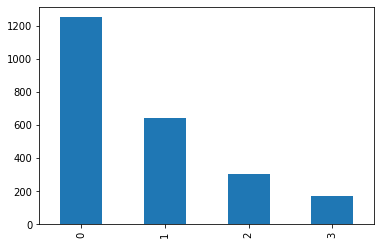

In [0]:
df_for_model['Class'].value_counts().plot.bar()

In [0]:
train_validate_df, final_test_df = train_test_split(df_for_model, test_size=0.15, stratify = df_for_model['Class'].values, random_state=42)

train_validate_df = train_validate_df.reset_index(drop=True)
test_df = final_test_df.reset_index(drop=True)

In [0]:
def augmentasiTrain(training_df):
  def append_psf(id):
      return "Pitch Shift FoHS/"+id

  def append_tsn(id):
      return "Time Stretch NoLim/"+id
  
  def append_tss(id):
      return "Time Stretch SaLim/"+id

  df_PSF = training_df.copy()
  df_PSF["Id"]=df_PSF["Id"].apply(append_psf)
  df_TSN = training_df.copy()
  df_TSN["Id"]=df_TSN["Id"].apply(append_tsn)
  df_TSS = training_df.copy()
  df_TSS["Id"]=df_TSS["Id"].apply(append_tss)
  return pd.concat([training_df,df_PSF,df_TSN,df_TSS],ignore_index=True)

In [0]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color
IMAGE_SIZE_INPUT = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

batch_size=15

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

final_test_generator = datagen.flow_from_dataframe(
    final_test_df, 
    "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
    x_col='Id',
    y_col='Class',
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=1
)

Found 356 validated image filenames belonging to 4 classes.


In [0]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=patience_lr, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
    return [mcp_save, learning_rate_reduction]

In [0]:
def get_model():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), padding='same', activation='elu', input_shape=IMAGE_SIZE_INPUT))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='elu')) 
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='elu'))
  model.add(Dense(4, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0005, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [0]:
from sklearn.model_selection import cross_validate

with tf.device('/device:GPU:0'):  

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
  X = train_validate_df["Id"].values
  y = train_validate_df["Class"].values
  i = 1
  for train_index, test_index in skf.split(X, y):
    print(f"====================***   K-Fold {i}   ***====================")
    i+=1
    # Make Train and Validation DataFrame 
    TrainVal_dict = {"Id": X[train_index],"Class":y[train_index]}
    TrainVal_df = pd.DataFrame(TrainVal_dict)
    Train_df, Valid_df = train_test_split(TrainVal_df, test_size=0.30, stratify = TrainVal_df['Class'].values, random_state=42)
    Train_df = Train_df.reset_index(drop=True)
    Valid_df = Valid_df.reset_index(drop=True)
    Train_df = augmentasiTrain(Train_df)

    # Make Test DataFrame
    Test_dict = {"Id": X[test_index],"Class":y[test_index]}
    Test_df = pd.DataFrame(Test_dict)
    Test_df = Test_df.reset_index(drop=True)

    # Prepare the image
    Train_generator = datagen.flow_from_dataframe(
      Train_df, 
      "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
      x_col='Id',
      y_col='Class',
      target_size=IMAGE_SIZE,
      class_mode="categorical",
      batch_size=batch_size
    )
    Valid_generator = datagen.flow_from_dataframe(
      Valid_df, 
      "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
      x_col='Id',
      y_col='Class',
      target_size=IMAGE_SIZE,
      class_mode="categorical",
      batch_size=batch_size
    )
    Test_generator = datagen.flow_from_dataframe(
      Test_df, 
      "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
      x_col='Id',
      y_col='Class',
      target_size=IMAGE_SIZE,
      class_mode="categorical",
      batch_size=1
    )

    # Callbacks
    name_weights = "final_model_fold" + str(i) + "_weights.h5"
    callbacks = get_callbacks(name_weights=name_weights, patience_lr=2)

    # Fitting
    model = get_model()
    history = model.fit(
      Train_generator, 
      epochs=15,
      validation_data=Valid_generator,
      validation_steps=Valid_df.shape[0]//batch_size,
      steps_per_epoch=Train_df.shape[0]//batch_size,
      callbacks=callbacks
    )

    test_loss, test_acc = model.evaluate(Test_generator, verbose=2)

    print(f'\nTest accuracy: {test_acc} \t Test loss: {test_loss}\n\n')

====================***   K-Fold 1   ***====================
Found 4508 validated image filenames belonging to 4 classes.
Found 483 validated image filenames belonging to 4 classes.
Found 403 validated image filenames belonging to 4 classes.
Epoch 1/15
300/300 [==============================] - 41s 135ms/step - loss: 5.7711 - accuracy: 0.4144 - val_loss: 1.8882 - val_accuracy: 0.5292 - lr: 5.0000e-04
Epoch 2/15
300/300 [==============================] - 34s 114ms/step - loss: 1.4541 - accuracy: 0.4690 - val_loss: 1.2153 - val_accuracy: 0.5312 - lr: 5.0000e-04
Epoch 3/15
300/300 [==============================] - 32s 107ms/step - loss: 1.2790 - accuracy: 0.5101 - val_loss: 1.3250 - val_accuracy: 0.5146 - lr: 5.0000e-04
Epoch 4/15
300/300 [==============================] - ETA: 0s - loss: 1.2311 - accuracy: 0.5175
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
300/300 [==============================] - 33s 109ms/step - loss: 1.2311 - accuracy: 0.5175 - va

In [0]:
final_train_df, final_validate_df = train_test_split(train_validate_df, test_size=0.2, stratify = train_validate_df['Class'].values, random_state=42)

print(f'Jumlah data train : {len(final_train_df)} ( {round(len(final_train_df)/len(df_for_model)*100,2)} % )')
print(f'Jumlah data validasi : {len(final_validate_df)} ( {round(len(final_validate_df)/len(df_for_model)*100,2)} % )')
print(f'Jumlah data test : {len(final_test_df)} ( {round(len(final_test_df)/len(df_for_model)*100,2)} % )')

Jumlah data train : 1610 ( 67.96 % )
Jumlah data validasi : 403 ( 17.01 % )
Jumlah data test : 356 ( 15.03 % )


In [0]:
final_train_df = final_train_df.reset_index(drop=True)
final_validate_df = final_validate_df.reset_index(drop=True)
final_train_df_augmented = augmentasiTrain(final_train_df)
print(f'Jumlah data train setelah ditambah augmentasi : {len(final_train_df_augmented)}')

Jumlah data train setelah ditambah augmentasi : 6440


In [0]:
final_train_generator = datagen.flow_from_dataframe(
    final_train_df_augmented, 
    "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
    x_col='Id',
    y_col='Class',
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size
)

final_validate_generator = datagen.flow_from_dataframe(
    final_validate_df, 
    "/content/gdrive/My Drive/Code TA/Data/Spectogram Librosa", 
    x_col='Id',
    y_col='Class',
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size
)

Found 6440 validated image filenames belonging to 4 classes.
Found 403 validated image filenames belonging to 4 classes.


In [0]:
with tf.device('/device:GPU:0'): 
    # Callbacks
    name_weights = "CNN_with_CrossVal_final_model_weights.h5"
    callbacks = get_callbacks(name_weights=name_weights, patience_lr=2)

    # Fitting
    model = get_model()
    history = model.fit(
      final_train_generator, 
      epochs=45,
      validation_data=final_validate_generator,
      validation_steps=final_validate_df.shape[0]//batch_size,
      steps_per_epoch=final_train_df_augmented.shape[0]//batch_size,
      callbacks=callbacks
    )

Epoch 1/45
429/429 [==============================] - 46s 108ms/step - loss: 4.9646 - accuracy: 0.4384 - val_loss: 1.2129 - val_accuracy: 0.5231 - lr: 5.0000e-04
Epoch 2/45
429/429 [==============================] - 46s 108ms/step - loss: 1.2541 - accuracy: 0.4945 - val_loss: 1.1583 - val_accuracy: 0.5282 - lr: 5.0000e-04
Epoch 3/45
429/429 [==============================] - 46s 107ms/step - loss: 1.2207 - accuracy: 0.5156 - val_loss: 1.1072 - val_accuracy: 0.5308 - lr: 5.0000e-04
Epoch 4/45
429/429 [==============================] - 45s 104ms/step - loss: 1.2051 - accuracy: 0.5138 - val_loss: 1.1618 - val_accuracy: 0.5308 - lr: 5.0000e-04
Epoch 5/45
429/429 [==============================] - ETA: 0s - loss: 1.1975 - accuracy: 0.5163
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
429/429 [==============================] - 44s 102ms/step - loss: 1.1975 - accuracy: 0.5163 - val_loss: 1.1506 - val_accuracy: 0.5256 - lr: 5.0000e-04
Epoch 6/45
429/429 [=====

In [0]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_78 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_79 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 56, 56, 128)     

In [0]:
test_loss, test_acc = model.evaluate(final_test_generator, verbose=2)

print(f'\nTest accuracy: {test_acc} \t Test loss: {test_loss}\n\n')

356/356 - 193s - loss: 0.7493 - accuracy: 0.7753

Test accuracy: 0.7752808928489685 	 Test loss: 0.7492857575416565




In [0]:
# Save Model
# Save the weights
model.save_weights('HASIL_TA_model_weights.h5')

# Save the model architecture
with open('HASIL_TA_model_architecture.json', 'w') as f:
    f.write(model.to_json())

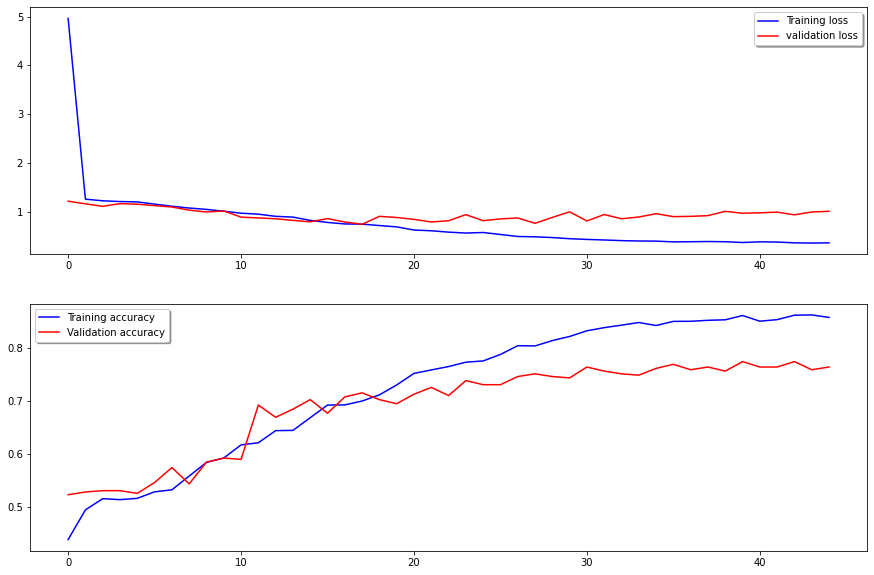

In [0]:
#Virtualize Training

fig, ax = plt.subplots(2,1)
plt.gcf().set_size_inches(15, 10)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)